In [1]:
import ROOT

Welcome to JupyROOT 6.24/07


In [2]:
ROOT.gSystem.Load('./RooMultiVarGaussian2e_cxx.so')

0


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import sys
import time

In [5]:
#input_filebase = 'bootstrap-9d-output-test1b'
input_filebase = 'bootstrap-9d-output-test1g-diagonal-cov'

In [6]:
with open('%s.npy' % input_filebase,'rb') as f :
    train_pts = np.load(f)
    train_det_pts = np.load(f)
    true_pts = np.load(f)
    true_det_pts = np.load(f)
    bootstrap_weights = np.load(f)

In [7]:
nboot = len(bootstrap_weights)
nmcevts = len(train_pts)

print( "train_pts shape:  %s" % str(train_pts.shape))
print( "bootstrap_weights:  %s" % str(bootstrap_weights.shape))
print( "number of bootstraps: %d" % nboot)
print( "number of MC events: %d" % nmcevts)

train_pts shape:  (400000, 9)
bootstrap_weights:  (50, 400000)
number of bootstraps: 50
number of MC events: 400000


In [8]:
ndim = 9

true_mu = [ 0.8,  0.1,  -0.6,   0.3,  1.3,  0.2,   -0.5,  0.2,  0.6 ]


#true_rho  = [ 
#              [0.0, 0.0, 0.1,   -0.1, 0.1, -0.3,     0.5, 0.6],  #0
#              [0.0, -0.1, 0.2,     0.3, 0.4, 0.4,      0.7],  #1
#              [0.0, 0.1, 0.2,   -0.3, -0.5, 0.6],  #2
#              [0.0, -0.3, -0.4,     0.6, -0.7],  #3
#              [-0.1, 0.2, 0.4,   -0.6],  #4
#              [0.0, 0.0, 0.3],  #5
#              [0.0, -0.3],  #6
#              [0.2]  #7
#            ]


true_rho = [ 
              [0., 0., 0.,   0., 0., 0.,     0., 0.],  #0
              [0., 0., 0.,   0., 0., 0.,     0.],  #1
              [0., 0., 0.,   0., 0., 0.],  #2
              [0., 0., 0.,   0., 0.],  #3
              [0., 0., 0.,   0.],  #4
              [0., 0., 0.],  #5
              [0., 0.],  #6
              [0.]  #7
            ]



true_sig = [ 0.8, 0.6, 1.0,    0.6, 1.2, 0.3,    0.3, 0.5, 1.0 ]

true_cov  = np.zeros( shape=(ndim,ndim) )

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d : diagonal  %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
   

   0,  0 : diagonal    0.6400
   0,  1 : diagonal     0.800 *    0.600 *    0.000 =   0.0000
   0,  2 : diagonal     0.800 *    1.000 *    0.000 =   0.0000
   0,  3 : diagonal     0.800 *    0.600 *    0.000 =   0.0000
   0,  4 : diagonal     0.800 *    1.200 *    0.000 =   0.0000
   0,  5 : diagonal     0.800 *    0.300 *    0.000 =   0.0000
   0,  6 : diagonal     0.800 *    0.300 *    0.000 =   0.0000
   0,  7 : diagonal     0.800 *    0.500 *    0.000 =   0.0000
   0,  8 : diagonal     0.800 *    1.000 *    0.000 =   0.0000
   1,  1 : diagonal    0.3600
   1,  2 : diagonal     0.600 *    1.000 *    0.000 =   0.0000
   1,  3 : diagonal     0.600 *    0.600 *    0.000 =   0.0000
   1,  4 : diagonal     0.600 *    1.200 *    0.000 =   0.0000
   1,  5 : diagonal     0.600 *    0.300 *    0.000 =   0.0000
   1,  6 : diagonal     0.600 *    0.300 *    0.000 =   0.0000
   1,  7 : diagonal     0.600 *    0.500 *    0.000 =   0.0000
   1,  8 : diagonal     0.600 *    1.000 *    0.000 =   0.

###  Do it this way to keep all the RooRealVars in memory in separate objects (different elements in the dictionary).

In [9]:
covdict = {}


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        if ( i == j ) :
            covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), true_cov[i][j], 0.02, 2.0 )           
        else :
            covdict[vname] =   ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), true_cov[i][j], -1.1, 1.1 ) 



In [10]:
covRAL = ROOT.RooArgList()


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        covRAL.add( covdict[vname] )


In [11]:
ralind = 0
for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        print( "  %d, %d :  %2d :  %s  %8.3f" % (i,j, ralind, covRAL.at(ralind).GetName(), covRAL.at(ralind).getVal() )) 
        ralind = ralind + 1

  0, 0 :   0 :  cov00     0.640
  0, 1 :   1 :  cov01     0.000
  0, 2 :   2 :  cov02     0.000
  0, 3 :   3 :  cov03     0.000
  0, 4 :   4 :  cov04     0.000
  0, 5 :   5 :  cov05     0.000
  0, 6 :   6 :  cov06     0.000
  0, 7 :   7 :  cov07     0.000
  0, 8 :   8 :  cov08     0.000
  1, 1 :   9 :  cov11     0.360
  1, 2 :  10 :  cov12     0.000
  1, 3 :  11 :  cov13     0.000
  1, 4 :  12 :  cov14     0.000
  1, 5 :  13 :  cov15     0.000
  1, 6 :  14 :  cov16     0.000
  1, 7 :  15 :  cov17     0.000
  1, 8 :  16 :  cov18     0.000
  2, 2 :  17 :  cov22     1.000
  2, 3 :  18 :  cov23     0.000
  2, 4 :  19 :  cov24     0.000
  2, 5 :  20 :  cov25     0.000
  2, 6 :  21 :  cov26     0.000
  2, 7 :  22 :  cov27     0.000
  2, 8 :  23 :  cov28     0.000
  3, 3 :  24 :  cov33     0.360
  3, 4 :  25 :  cov34     0.000
  3, 5 :  26 :  cov35     0.000
  3, 6 :  27 :  cov36     0.000
  3, 7 :  28 :  cov37     0.000
  3, 8 :  29 :  cov38     0.000
  4, 4 :  30 :  cov44     1.440
  4, 5 :

### The Dict keeps the variables defined in memory

In [12]:
xDict = {}
muDict = {}

xVec = ROOT.RooArgList()
muVec = ROOT.RooArgList()


for i in range(ndim) :
    vname = "x%d" % i
    xDict[vname] = ROOT.RooRealVar( vname, vname, 0., -5., 5. )
    xVec.add( xDict[vname] )
    vname = "mu_x%d" % i
    muDict[vname] =  ROOT.RooRealVar( vname, vname, true_mu[i], -2., 2. )
    muVec.add( muDict[vname] )
    
weight = ROOT.RooRealVar("weight","weight", 0., 100. )

In [13]:
rmvg = ROOT.RooMultiVarGaussian2e("rmvg","rmvg", xVec, muVec, covRAL )

  Setting _prevCovVals[0] to 0.640000
  Setting _prevCovVals[1] to 0.000000
  Setting _prevCovVals[2] to 0.000000
  Setting _prevCovVals[3] to 0.000000
  Setting _prevCovVals[4] to 0.000000
  Setting _prevCovVals[5] to 0.000000
  Setting _prevCovVals[6] to 0.000000
  Setting _prevCovVals[7] to 0.000000
  Setting _prevCovVals[8] to 0.000000
  Setting _prevCovVals[9] to 0.360000
  Setting _prevCovVals[10] to 0.000000
  Setting _prevCovVals[11] to 0.000000
  Setting _prevCovVals[12] to 0.000000
  Setting _prevCovVals[13] to 0.000000
  Setting _prevCovVals[14] to 0.000000
  Setting _prevCovVals[15] to 0.000000
  Setting _prevCovVals[16] to 0.000000
  Setting _prevCovVals[17] to 1.000000
  Setting _prevCovVals[18] to 0.000000
  Setting _prevCovVals[19] to 0.000000
  Setting _prevCovVals[20] to 0.000000
  Setting _prevCovVals[21] to 0.000000
  Setting _prevCovVals[22] to 0.000000
  Setting _prevCovVals[23] to 0.000000
  Setting _prevCovVals[24] to 0.360000
  Setting _prevCovVals[25] to 0.000

In [14]:
fit_mean = np.zeros( shape=( muVec.size(), len(bootstrap_weights)))
fit_cov_diag = np.zeros( shape=( muVec.size(), len(bootstrap_weights)))

In [15]:
fit_mean.shape

(9, 50)

In [16]:
fit_mean[:,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
fit_mean[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
fit_mean[:,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
xVec.Print("V")

  1) RooRealVar:: x0 = 0
  2) RooRealVar:: x1 = 0
  3) RooRealVar:: x2 = 0
  4) RooRealVar:: x3 = 0
  5) RooRealVar:: x4 = 0
  6) RooRealVar:: x5 = 0
  7) RooRealVar:: x6 = 0
  8) RooRealVar:: x7 = 0
  9) RooRealVar:: x8 = 0


In [20]:
data_test = ROOT.RooDataSet( "data_test", "data_test", ROOT.RooArgSet(xVec, weight) , ROOT.RooFit.WeightVar("weight"))

In [21]:
bi = 0
for i in range( 1000 ) :
    for j in range( ndim ) :
        xVec[j].setVal( train_pts[i,j] )
    weight.setVal( bootstrap_weights[bi,i])
    data_test.add( ROOT.RooArgSet(xVec, weight), weight.getVal() )

In [22]:
data_test

In [23]:
data_test.Print("V")

DataStore data_test (data_test)
  Contains 1000 entries
  Observables: 
    1)  x0 = 0.609803  L(-5 - 5)  "x0"
    2)  x1 = -0.0797489  L(-5 - 5)  "x1"
    3)  x2 = -0.273098  L(-5 - 5)  "x2"
    4)  x3 = 1.19357  L(-5 - 5)  "x3"
    5)  x4 = 1.67007  L(-5 - 5)  "x4"
    6)  x5 = 0.0654762  L(-5 - 5)  "x5"
    7)  x6 = 0.528855  L(-5 - 5)  "x6"
    8)  x7 = 0.238921  L(-5 - 5)  "x7"
    9)  x8 = -0.944003  L(-5 - 5)  "x8"
  Dataset variable "weight" is interpreted as the event weight


In [24]:
data_test.get(0).Print("V")

  1) RooRealVar:: x0 = 0.638712
  2) RooRealVar:: x1 = -0.651805
  3) RooRealVar:: x2 = -0.994293
  4) RooRealVar:: x3 = 0.521374
  5) RooRealVar:: x4 = 4.91736
  6) RooRealVar:: x5 = -0.289682
  7) RooRealVar:: x6 = -0.359264
  8) RooRealVar:: x7 = 0.708582
  9) RooRealVar:: x8 = 1.17321


In [25]:

for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        if ( i == j ) : continue
        vname = "cov%d%d" % (i,j)
        covRAL.find(vname).setConstant()

In [26]:
covRAL.Print("V")

  1) RooRealVar:: cov00 = 0.64
  2) RooRealVar:: cov01 = 0
  3) RooRealVar:: cov02 = 0
  4) RooRealVar:: cov03 = 0
  5) RooRealVar:: cov04 = 0
  6) RooRealVar:: cov05 = 0
  7) RooRealVar:: cov06 = 0
  8) RooRealVar:: cov07 = 0
  9) RooRealVar:: cov08 = 0
 10) RooRealVar:: cov11 = 0.36
 11) RooRealVar:: cov12 = 0
 12) RooRealVar:: cov13 = 0
 13) RooRealVar:: cov14 = 0
 14) RooRealVar:: cov15 = 0
 15) RooRealVar:: cov16 = 0
 16) RooRealVar:: cov17 = 0
 17) RooRealVar:: cov18 = 0
 18) RooRealVar:: cov22 = 1
 19) RooRealVar:: cov23 = 0
 20) RooRealVar:: cov24 = 0
 21) RooRealVar:: cov25 = 0
 22) RooRealVar:: cov26 = 0
 23) RooRealVar:: cov27 = 0
 24) RooRealVar:: cov28 = 0
 25) RooRealVar:: cov33 = 0.36
 26) RooRealVar:: cov34 = 0
 27) RooRealVar:: cov35 = 0
 28) RooRealVar:: cov36 = 0
 29) RooRealVar:: cov37 = 0
 30) RooRealVar:: cov38 = 0
 31) RooRealVar:: cov44 = 1.44
 32) RooRealVar:: cov45 = 0
 33) RooRealVar:: cov46 = 0
 34) RooRealVar:: cov47 = 0
 35) RooRealVar:: cov48 = 0
 36) Roo

In [27]:
covRAL.find("cov00").isConstant()

False

In [28]:
covRAL.find("cov01").isConstant()

True

In [29]:
rfr = rmvg.fitTo( data_test, ROOT.RooFit.SumW2Error(False), ROOT.RooFit.Save(True), ROOT.RooFit.NumCPU(28))
#rfr = rmvg.fitTo( data_test, ROOT.RooFit.SumW2Error(False), ROOT.RooFit.Save(True))


[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
  copy constructor, Setting _prevCovVals[0] to 0.640000
  copy constructor, Setting _prevCovVals[1] to 0.000000
  copy constructor, Setting _prevCovVals[2] to 0.000000
  copy constructor, Setting _prevCovVals[3] to 0.000000
  copy constructor, Setting _prevCovVals[4] to 0.000000
  copy constructor, Setting _prevCovVals[5] to 0.000000
  copy constructor, Setting _prevCovVals[6] to 0.000000
  copy constructor, Setting _prevCovVals[7] to 0.000000
  copy constructor, Setting _prevCovVals[8] to 0.000000
  copy constructor, Setting _prevCovVals[9] to 0.360000
  copy constructor, Setting _prevCovVals[10] to 0.000000
  copy constructor, Setting _prevCovVals[11] to 0.000000
  copy constructor, Setting _prevCovVals[12] to 0.000000
  copy constructor, Setting _prevCovVals[13] to 0.000000
  copy constructor, Setting _prevCovVals[14] to 0.000000
  copy constructor, Setting _prevCovVals[15] to 0.000000
  copy construc

In [30]:
%%time

for bi in range( len(bootstrap_weights) ) :
    
    print("\n\n --- bootstrap sample %3d" % bi, flush=True )
    sys.stdout.flush()
    
    data_weighted = ROOT.RooDataSet("data_weighted","data_weighted", ROOT.RooArgSet(xVec,weight), ROOT.RooFit.WeightVar("weight"))
    
    for i in range( len(train_pts) ) :
        for j in range( ndim ) :
            xVec[j].setVal( train_pts[i,j] )
        weight.setVal(bootstrap_weights[bi,i])
        data_weighted.add( ROOT.RooArgSet(xVec,weight), weight.getVal())
        
    print("  Running fit...")
        
    rfr = rmvg.fitTo( data_weighted, ROOT.RooFit.SumW2Error(True), ROOT.RooFit.Save(True), ROOT.RooFit.NumCPU(28))
    
    for i in range(ndim) :
        fit_mean[i,bi] = muDict[ "mu_x%d" % i ].getVal()
        fit_cov_diag[i,bi] = covdict[ "cov%d%d" % (i,i) ].getVal()
        print("   %2d :  mu = %8.3f   (true %8.3f) ,  cov = %8.3f  (true %8.3f)" % 
              ( i, fit_mean[i,bi], true_mu[i], fit_cov_diag[i,bi], (true_sig[i]*true_sig[i])))
    
    
    



 --- bootstrap sample   0
  Running fit...
    0 :  mu =    0.793   (true    0.800) ,  cov =    0.673  (true    0.640)
    1 :  mu =    0.103   (true    0.100) ,  cov =    0.374  (true    0.360)
    2 :  mu =   -0.569   (true   -0.600) ,  cov =    1.036  (true    1.000)
    3 :  mu =    0.290   (true    0.300) ,  cov =    0.354  (true    0.360)
    4 :  mu =    1.259   (true    1.300) ,  cov =    1.498  (true    1.440)
    5 :  mu =    0.207   (true    0.200) ,  cov =    0.108  (true    0.090)
    6 :  mu =   -0.497   (true   -0.500) ,  cov =    0.131  (true    0.090)
    7 :  mu =    0.203   (true    0.200) ,  cov =    0.273  (true    0.250)
    8 :  mu =    0.607   (true    0.600) ,  cov =    0.991  (true    1.000)


 --- bootstrap sample   1
  Running fit...
    0 :  mu =    0.815   (true    0.800) ,  cov =    0.659  (true    0.640)
    1 :  mu =    0.096   (true    0.100) ,  cov =    0.371  (true    0.360)
    2 :  mu =   -0.577   (true   -0.600) ,  cov =    1.017  (true    1.000

  Running fit...
    0 :  mu =    0.775   (true    0.800) ,  cov =    0.670  (true    0.640)
    1 :  mu =    0.100   (true    0.100) ,  cov =    0.385  (true    0.360)
    2 :  mu =   -0.570   (true   -0.600) ,  cov =    1.014  (true    1.000)
    3 :  mu =    0.294   (true    0.300) ,  cov =    0.369  (true    0.360)
    4 :  mu =    1.323   (true    1.300) ,  cov =    1.435  (true    1.440)
    5 :  mu =    0.203   (true    0.200) ,  cov =    0.107  (true    0.090)
    6 :  mu =   -0.502   (true   -0.500) ,  cov =    0.132  (true    0.090)
    7 :  mu =    0.214   (true    0.200) ,  cov =    0.279  (true    0.250)
    8 :  mu =    0.618   (true    0.600) ,  cov =    1.077  (true    1.000)


 --- bootstrap sample  13
  Running fit...
    0 :  mu =    0.758   (true    0.800) ,  cov =    0.711  (true    0.640)
    1 :  mu =    0.107   (true    0.100) ,  cov =    0.389  (true    0.360)
    2 :  mu =   -0.577   (true   -0.600) ,  cov =    1.064  (true    1.000)
    3 :  mu =    0.315   (

  Running fit...
    0 :  mu =    0.794   (true    0.800) ,  cov =    0.746  (true    0.640)
    1 :  mu =    0.098   (true    0.100) ,  cov =    0.368  (true    0.360)
    2 :  mu =   -0.576   (true   -0.600) ,  cov =    1.089  (true    1.000)
    3 :  mu =    0.299   (true    0.300) ,  cov =    0.372  (true    0.360)
    4 :  mu =    1.290   (true    1.300) ,  cov =    1.444  (true    1.440)
    5 :  mu =    0.196   (true    0.200) ,  cov =    0.108  (true    0.090)
    6 :  mu =   -0.499   (true   -0.500) ,  cov =    0.128  (true    0.090)
    7 :  mu =    0.203   (true    0.200) ,  cov =    0.251  (true    0.250)
    8 :  mu =    0.634   (true    0.600) ,  cov =    1.038  (true    1.000)


 --- bootstrap sample  25
  Running fit...
    0 :  mu =    0.793   (true    0.800) ,  cov =    0.718  (true    0.640)
    1 :  mu =    0.114   (true    0.100) ,  cov =    0.373  (true    0.360)
    2 :  mu =   -0.577   (true   -0.600) ,  cov =    1.026  (true    1.000)
    3 :  mu =    0.284   (

  Running fit...
    0 :  mu =    0.823   (true    0.800) ,  cov =    0.674  (true    0.640)
    1 :  mu =    0.085   (true    0.100) ,  cov =    0.384  (true    0.360)
    2 :  mu =   -0.629   (true   -0.600) ,  cov =    1.038  (true    1.000)
    3 :  mu =    0.315   (true    0.300) ,  cov =    0.405  (true    0.360)
    4 :  mu =    1.324   (true    1.300) ,  cov =    1.486  (true    1.440)
    5 :  mu =    0.242   (true    0.200) ,  cov =    0.124  (true    0.090)
    6 :  mu =   -0.504   (true   -0.500) ,  cov =    0.143  (true    0.090)
    7 :  mu =    0.194   (true    0.200) ,  cov =    0.341  (true    0.250)
    8 :  mu =    0.607   (true    0.600) ,  cov =    0.951  (true    1.000)


 --- bootstrap sample  37
  Running fit...
    0 :  mu =    0.801   (true    0.800) ,  cov =    0.655  (true    0.640)
    1 :  mu =    0.100   (true    0.100) ,  cov =    0.379  (true    0.360)
    2 :  mu =   -0.589   (true   -0.600) ,  cov =    1.015  (true    1.000)
    3 :  mu =    0.302   (

  Running fit...
    0 :  mu =    0.812   (true    0.800) ,  cov =    0.660  (true    0.640)
    1 :  mu =    0.087   (true    0.100) ,  cov =    0.394  (true    0.360)
    2 :  mu =   -0.590   (true   -0.600) ,  cov =    0.996  (true    1.000)
    3 :  mu =    0.308   (true    0.300) ,  cov =    0.372  (true    0.360)
    4 :  mu =    1.292   (true    1.300) ,  cov =    1.424  (true    1.440)
    5 :  mu =    0.202   (true    0.200) ,  cov =    0.109  (true    0.090)
    6 :  mu =   -0.501   (true   -0.500) ,  cov =    0.130  (true    0.090)
    7 :  mu =    0.199   (true    0.200) ,  cov =    0.270  (true    0.250)
    8 :  mu =    0.612   (true    0.600) ,  cov =    0.983  (true    1.000)


 --- bootstrap sample  49
  Running fit...
    0 :  mu =    0.799   (true    0.800) ,  cov =    0.692  (true    0.640)
    1 :  mu =    0.117   (true    0.100) ,  cov =    0.380  (true    0.360)
    2 :  mu =   -0.601   (true   -0.600) ,  cov =    1.036  (true    1.000)
    3 :  mu =    0.290   (

In [31]:
fit_mean

array([[ 0.79332609,  0.8154252 ,  0.78506761,  0.79652199,  0.80097743,
         0.79946948,  0.79416126,  0.78254371,  0.78629379,  0.80733902,
         0.76699034,  0.77141858,  0.77468657,  0.75775197,  0.78520561,
         0.77093067,  0.76743156,  0.83495994,  0.72239168,  0.78140973,
         0.9039891 ,  0.77559815,  0.80614891,  0.80964512,  0.79423805,
         0.79272422,  0.7844674 ,  0.79780179,  0.77831038,  0.79977531,
         0.79052465,  0.78822848,  0.78269756,  0.78998612,  0.77297412,
         0.78339939,  0.8230526 ,  0.80119757,  0.80614039,  0.83925812,
         0.79175315,  0.79815458,  0.79799302,  0.81029067,  0.80955689,
         0.79731035,  0.79973267,  0.79129907,  0.8118308 ,  0.79869648],
       [ 0.10297424,  0.09567953,  0.0844018 ,  0.10405851,  0.10934334,
         0.09745392,  0.11317377,  0.10497068,  0.11048472,  0.11251853,
         0.10077525,  0.09687467,  0.10014087,  0.1065067 ,  0.07957947,
         0.0962614 ,  0.08741275,  0.10813162,  0.

In [32]:
fit_cov_diag

array([[0.67329131, 0.65912777, 0.66669955, 0.66691678, 0.68713788,
        0.69021197, 0.67954447, 0.69998412, 0.69991724, 0.71852644,
        0.6542786 , 0.67328211, 0.66953889, 0.71056329, 0.64629391,
        0.65433032, 0.68908117, 0.71032048, 0.72569829, 0.69621065,
        0.84600233, 0.66608026, 0.62824768, 0.69799433, 0.7463277 ,
        0.71842737, 0.64033372, 0.65172005, 0.65101219, 0.65900168,
        0.6707673 , 0.7053892 , 0.67925133, 0.67457031, 0.66457805,
        0.65898112, 0.67426612, 0.65526246, 0.65654833, 0.72428636,
        0.64736825, 0.66058424, 0.66374547, 0.69832124, 0.65204945,
        0.65756747, 0.6841211 , 0.63376085, 0.65978669, 0.69184399],
       [0.37438806, 0.37068499, 0.35896306, 0.36809177, 0.37817416,
        0.39411541, 0.36487502, 0.38747756, 0.36015497, 0.37533661,
        0.35183355, 0.36152648, 0.38506126, 0.38913928, 0.36355495,
        0.36824778, 0.36040506, 0.35618915, 0.36132885, 0.39397996,
        0.34880972, 0.36748008, 0.38280031, 0.3

<function matplotlib.pyplot.show(close=None, block=None)>

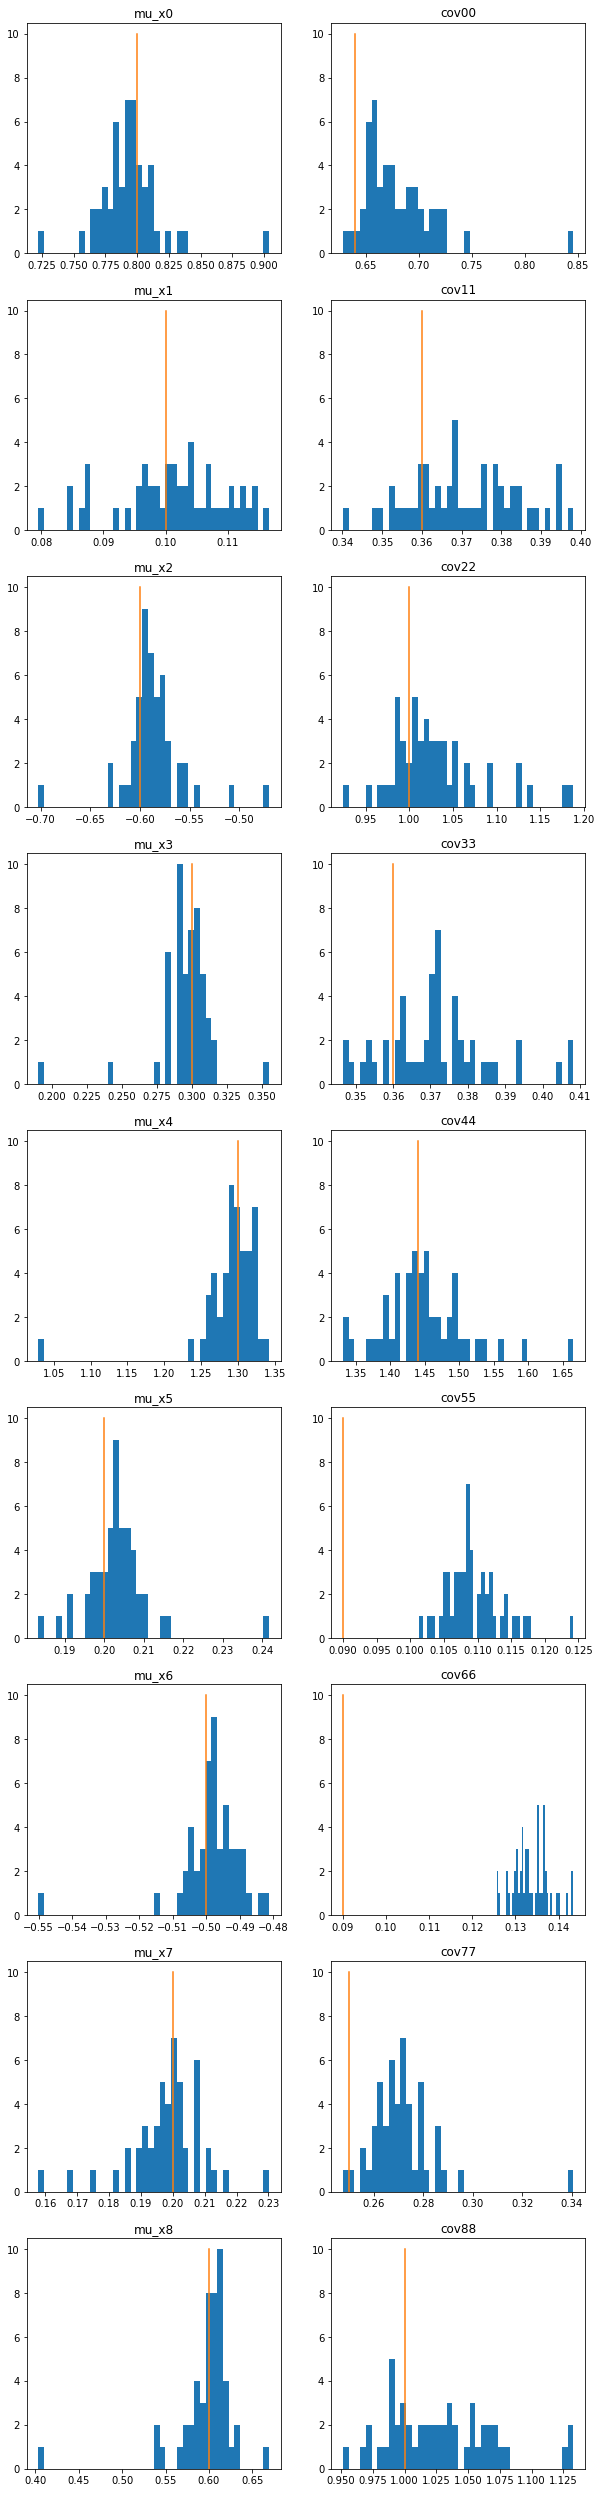

In [45]:
fig,ax = plt.subplots( ndim, 2, figsize=(10,5*ndim))

hbins=40

for i in range(ndim) :
    ax[i][0].hist( fit_mean[i,:], bins=hbins)
    ax[i][1].hist( fit_cov_diag[i,:], bins=hbins)
    ax[i][0].plot( [true_mu[i], true_mu[i]], [0,10])
    ax[i][1].plot( [true_sig[i]*true_sig[i], true_sig[i]*true_sig[i]], [0,10])
    ax[i][0].set_title( 'mu_x%d' % i )
    ax[i][1].set_title( 'cov%d%d' % (i,i) )

plt.show